In [1]:
Alpha_Name = "AlphaNet_Original_Input_10d_return"
start_time = "2021-01-01"
forecast_months = 6 # months
feat_num = 9

In [2]:
from os import walk
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from progressbar import ProgressBar
from tqdm import tqdm
import torch.utils.data as Data
import torch.optim as optim
from tqdm import tqdm
from torch.autograd import Variable
import time
import multiprocessing as mp
from os import walk
import matplotlib.pyplot as plt
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/result/"
model_dir = "/home/wuwenjun/Alpha_Factor/" + Alpha_Name + "/model/"
if os.path.exists(output_path) == False:
    os.makedirs(output_path)

In [3]:
time_list = []
data_path = path + "Final/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
for count,item in enumerate(time_list):
    if item.startswith(start_time):
        train_timestamp = time_list[:count]
        test_timestamp = time_list[count:count + forecast_months//3]
        break
display(train_timestamp)
display(test_timestamp)

model_path = (model_dir + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]).replace(".par","/")
if os.path.exists(model_path) == False:
    os.makedirs(model_path)

100%|██████████| 26/26 [00:00<00:00, 170927.75it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par',
 '2020-01-01_2020-03-01.par',
 '2020-03-01_2020-06-01.par',
 '2020-06-01_2020-09-01.par',
 '2020-09-01_2021-01-01.par']

['2021-01-01_2021-03-01.par', '2021-03-01_2021-06-01.par']

In [4]:
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)


for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 24/24 [02:10<00:00,  5.43s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.284385,0.015374,-0.376716,1.522075,1.214418,0.876160,3.017927,2.407912,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,0.240629,-0.664319,-1.631951,1.601496,1.196133,0.839082,3.175407,2.371658,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,0.292173,-0.412251,-1.377793,1.574869,1.150095,0.797058,3.122595,2.280374,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,0.038896,-0.273104,-0.482991,1.643798,1.129884,0.739729,3.259280,2.240302,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,0.381687,-0.105721,-0.411738,1.581575,1.170118,0.769491,3.135918,2.320080,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25 09:30:00,688981,0.376847,0.558021,7.531216,0.289600,0.857656,8.524438,0.415018,0.554211,7.358793,0.274589,...,223858.592000,0.426938,-0.450167,-0.979651,3.405911,2.961648,2.151998,3.405911,2.961648,2.151998
2020-12-28 09:30:00,688981,0.875378,0.480857,6.125189,0.763667,0.835368,6.400609,0.808300,0.502249,5.499779,0.747445,...,211736.222545,0.348475,-0.407559,-0.959076,3.520044,2.864427,2.035465,3.520044,2.864427,2.035465
2020-12-29 09:30:00,688981,0.713691,0.488609,3.956496,0.914182,0.635866,3.450882,0.796116,0.431834,3.023371,0.773336,...,229583.868909,0.171973,-0.479122,-1.200438,3.282189,2.779050,2.207042,3.282189,2.779050,2.207042


timestamp            ticker
2015-02-16 09:30:00  1        -1.020014
2015-02-17 09:30:00  1        -0.796300
2015-02-25 09:30:00  1        -0.606755
2015-02-26 09:30:00  1        -0.363449
2015-02-27 09:30:00  1         0.047813
                                 ...   
2020-12-25 09:30:00  688981    1.980807
2020-12-28 09:30:00  688981    2.091656
2020-12-29 09:30:00  688981    2.066666
2020-12-30 09:30:00  688981    2.100103
2020-12-31 09:30:00  688981    1.563590
Name: target, Length: 4733596, dtype: float64

100%|██████████| 2/2 [00:11<00:00,  5.69s/it]


,,0,1,2,3,4,5,6,7,8,9,...,638,639,640,641,642,643,644,645,646,647
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,1,2086.209700,638.760711,2388.873944,1660.385500,562.793773,2197.613756,979.699228,517.784767,2115.005672,1682.629977,...,747249.646182,0.831236,0.334278,0.059224,0.480658,0.445462,0.385069,1.084467,1.005051,0.868782
2021-01-05 09:30:00,1,1225.113118,308.659348,2427.906478,1029.933871,138.327729,2365.284467,348.112816,36.047620,2280.152028,963.490433,...,800519.087636,0.094753,-0.178988,-0.452380,0.531104,0.474760,0.412522,1.198276,1.071155,0.930724
2021-01-06 09:30:00,1,1123.065644,283.267374,2433.073400,824.460522,242.783073,2378.538107,697.751556,199.968389,2261.251424,968.121446,...,823130.510545,-0.353407,-0.462695,-0.591845,0.611942,0.504363,0.424169,1.380649,1.137941,0.957016
2021-01-07 09:30:00,1,1914.092007,405.069927,1960.309756,1405.396413,443.601253,2437.533246,1376.581822,555.128400,1545.061384,1702.990270,...,867296.888000,1.043780,-0.145435,-0.760849,0.694847,0.534452,0.446925,1.567691,1.205836,1.008373
2021-01-08 09:30:00,1,2675.787573,1139.499867,2455.506700,1835.235471,849.026609,3196.175591,2044.546887,1069.184296,2244.427721,2275.057167,...,855178.941818,1.189207,-0.016916,-0.659202,0.736389,0.539636,0.440676,1.661433,1.217538,0.994285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25 09:30:00,688981,0.491390,0.330376,0.597377,0.378376,0.333682,0.604684,0.207140,0.161098,0.258099,0.441615,...,149832.195091,0.108298,-0.263067,-0.624627,1.831876,1.536821,1.367515,1.831876,1.536821,1.367515
2021-05-26 09:30:00,688981,0.366808,0.503432,0.422536,0.317736,0.462686,0.495469,0.250582,0.262870,0.149411,0.346992,...,141060.260000,0.212307,-0.143355,-0.321316,1.775511,1.514462,1.287460,1.775511,1.514462,1.287460
2021-05-27 09:30:00,688981,0.394747,0.451264,0.432110,0.267280,0.446866,0.399076,0.231393,0.129168,0.204787,0.333588,...,159065.190182,0.280824,-0.007820,-0.316825,1.676253,1.537945,1.451789,1.676253,1.537945,1.451789


timestamp            ticker
2021-01-04 09:30:00  1         2.080068
2021-01-05 09:30:00  1         2.542624
2021-01-06 09:30:00  1         2.731188
2021-01-07 09:30:00  1         1.487784
2021-01-08 09:30:00  1         0.894896
                                 ...   
2021-05-25 09:30:00  688981   -0.262939
2021-05-26 09:30:00  688981   -0.222002
2021-05-27 09:30:00  688981   -0.212631
2021-05-28 09:30:00  688981   -0.232948
2021-05-31 09:30:00  688981   -0.320272
Name: target, Length: 402680, dtype: float64

In [5]:
trainx = torch.from_numpy(np.array(trainx))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([4733596, 648])
trainy.shape:  torch.Size([4733596, 1])
testx.shape:  torch.Size([402680, 648])
testy.shape:  torch.Size([402680, 1])


In [6]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1024
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [7]:
class AlphaNet(nn.Module):
    def __init__(self, factor_num, fully_connect_layer_neural):
        super(AlphaNet, self).__init__()
        self.fc1_neuron = int((factor_num * (factor_num - 1)+ 4 * factor_num) * 3 * 2)
        self.fc2_neuron = fully_connect_layer_neural
        self.batch = torch.nn.BatchNorm1d(self.fc1_neuron)
        self.fc1 = torch.nn.Linear(self.fc1_neuron, self.fc2_neuron)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.out = nn.Linear(self.fc2_neuron, 1)

    def forward(self, x):
        x = self.batch(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        y_pred = self.out(x)
        return y_pred
# device=torch.device('cuda:0')

In [ ]:
alphanet = AlphaNet(feat_num, 30)
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
LR = 0.0001
loss_function = nn.MSELoss().cuda()
optimizer = optim.RMSprop(alphanet.parameters(), lr=LR, alpha=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2,gamma = 0.5)
epoch_num = 30
loss_list = []

min_loss = float("inf")
for epoch in tqdm(range(epoch_num)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
torch.save(alphanet,model_path + "model.tar")
np.save(model_path + "loss.npy", loss_list)

  0%|          | 0/30 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=648, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


In [9]:
# alphanet = torch.load(model_path + "best_model.tar")
# alphanet = alphanet.cuda()
# # alphanet = torch.nn.parallel.DataParallel(alphanet)
# print(alphanet)
# total_length = trainx.shape[0]
# LR = 0.0001
# loss_function = nn.MSELoss().cuda()
# optimizer = optim.RMSprop(alphanet.parameters(), lr=LR/10, alpha=0.9)
# loss_list = []
# min_loss = float("inf")
# for epoch in tqdm(range(20)):
#     total_loss = 0
#     for _, (inputs, outputs) in enumerate(train_loader):
#         inputs = Variable(inputs).float().cuda()
#         outputs = Variable(outputs).float().cuda()
#         optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
#         # forward + backward +update
#         pred = alphanet(inputs)
#         pred = pred.cuda()
#         loss = loss_function(pred, outputs)
#         loss.backward()
#         optimizer.step()
        
# #         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
#         total_loss += loss.item()
#     total_loss = total_loss * batch_size / total_length
#     print('Epoch: ', epoch + 1, ' loss: ', total_loss)
#     loss_list.append(total_loss)
#     if total_loss < min_loss:
#         torch.save(alphanet,model_path + "best_model.tar")
# torch.save(alphanet,model_path + "model.tar")
# np.save(model_path + "loss.npy", loss_list)

  0%|          | 0/20 [00:00<?, ?it/s]

AlphaNet(
  (batch): BatchNorm1d(648, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=648, out_features=30, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  5%|▌         | 1/20 [00:37<11:54, 37.63s/it]

Epoch:  1  loss:  0.7699094776135806


 10%|█         | 2/20 [01:13<10:55, 36.40s/it]

Epoch:  2  loss:  0.7693666494814071


 15%|█▌        | 3/20 [01:49<10:18, 36.39s/it]

Epoch:  3  loss:  0.7694220612076725


 20%|██        | 4/20 [02:26<09:45, 36.62s/it]

Epoch:  4  loss:  0.7694829180856229


 25%|██▌       | 5/20 [03:05<09:24, 37.64s/it]

Epoch:  5  loss:  0.7693399923361551


 30%|███       | 6/20 [03:44<08:50, 37.88s/it]

Epoch:  6  loss:  0.7693899193096323


 35%|███▌      | 7/20 [04:22<08:14, 38.03s/it]

Epoch:  7  loss:  0.7692924014464206


 40%|████      | 8/20 [05:02<07:44, 38.67s/it]

Epoch:  8  loss:  0.7693144381549617


 45%|████▌     | 9/20 [05:41<07:07, 38.83s/it]

Epoch:  9  loss:  0.7692135328720536


 50%|█████     | 10/20 [06:21<06:29, 38.97s/it]

Epoch:  10  loss:  0.7691375580969656


 55%|█████▌    | 11/20 [07:00<05:51, 39.00s/it]

Epoch:  11  loss:  0.7690551750273623


 60%|██████    | 12/20 [07:40<05:13, 39.24s/it]

Epoch:  12  loss:  0.7690384896598931


 65%|██████▌   | 13/20 [08:21<04:38, 39.85s/it]

Epoch:  13  loss:  0.7690678403255116


 70%|███████   | 14/20 [09:00<03:58, 39.73s/it]

Epoch:  14  loss:  0.7689480680796952


 75%|███████▌  | 15/20 [09:39<03:16, 39.31s/it]

Epoch:  15  loss:  0.7690843742407618


 80%|████████  | 16/20 [10:18<02:37, 39.30s/it]

Epoch:  16  loss:  0.7691383985643784


 85%|████████▌ | 17/20 [10:55<01:55, 38.66s/it]

Epoch:  17  loss:  0.7690527015717928


 90%|█████████ | 18/20 [11:33<01:17, 38.54s/it]

Epoch:  18  loss:  0.7689954821725047


 95%|█████████▌| 19/20 [12:12<00:38, 38.70s/it]

Epoch:  19  loss:  0.7688193394430484


100%|██████████| 20/20 [12:51<00:00, 38.57s/it]

Epoch:  20  loss:  0.7689466033375587


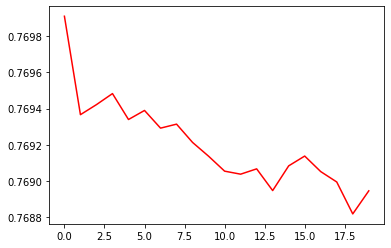

In [10]:
plt.plot(loss_list,color = 'r')
plt.savefig(model_path+"loss.png")

In [11]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [12]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_10d_return
0,2020-06-01 09:30:00,1,-0.630682,0.168322
1,2020-06-02 09:30:00,1,-0.511432,0.164309
2,2020-06-03 09:30:00,1,-0.898177,0.094020
3,2020-06-04 09:30:00,1,-0.867832,0.245846
4,2020-06-05 09:30:00,1,-0.937285,0.338732
...,...,...,...,...
572219,2020-12-25 09:30:00,688981,1.980807,-0.065521
572220,2020-12-28 09:30:00,688981,2.091656,0.018695
572221,2020-12-29 09:30:00,688981,2.066666,-0.055982
572222,2020-12-30 09:30:00,688981,2.100103,-0.211095


In [13]:
test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]

'2020-06-01_2021-01-01.par'

In [14]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])